<a href="https://colab.research.google.com/github/joaopamaral/deep-learning-v2-pytorch/blob/master/gan-mnist/MNIST_GAN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='https://github.com/joaopamaral/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/gan_pipeline.png?raw=1' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, I'll show you how to define and train these adversarial networks in PyTorch and generate new images!

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21660362.58it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 317426.37it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5226421.73it/s]                           
8192it [00:00, 130206.75it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### Visualize the data

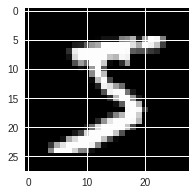

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='https://github.com/joaopamaral/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/gan_network.png?raw=1' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='https://github.com/joaopamaral/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/leaky_relu.png?raw=1' width=40% />

#### Sigmoid Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** and binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)        
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28 * 28)
        
        # pass x through all layers
        # apply leaky relu activation to all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        x = self.fc4(x)

        return x


## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

<img src='https://github.com/joaopamaral/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/tanh_fn.png?raw=1' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

I'll do this in the training loop, later on.

In [0]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define all layers
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)        
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)
        

    def forward(self, x):
        # pass x through all layers
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        # final layer should have tanh applied
        
        x = torch.tanh(self.fc4(x))
        
        return x

## Model hyperparameters

In [0]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of *last* hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of *first* hidden layer in the generator
g_hidden_size = 32

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [25]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

if train_on_gpu:
    D = D.cuda()
    G = G.cuda()

# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


---
## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='https://github.com/joaopamaral/deep-learning-v2-pytorch/blob/master/gan-mnist/assets/gan_pipeline.png?raw=1' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels. In PyTorch, this looks like `labels = torch.ones(size) * 0.9`

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [0]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # compare logits to real labels
    # smooth labels if smooth=True
    labels = torch.ones(batch_size)
    if smooth:
        labels *= 0.9
    if train_on_gpu:
        labels = labels.cuda()
    
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    # compare logits to fake labels
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [0]:
import torch.optim as optim

# learning rate for optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [28]:
import pickle as pkl
from tqdm.auto import tqdm

# training hyperparams
num_epochs = 40

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()
if train_on_gpu:
    fixed_z = fixed_z.cuda()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in tqdm(enumerate(train_loader)):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        if train_on_gpu:
            real_images = real_images.cuda()
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
                
        # 1. Train with real images
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)

        # Compute the discriminator losses on real images
        # use smoothed labels
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # add up real and fake losses and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)

        # perform backprop
        g_loss = real_loss(D_fake)
        g_loss.backward()
        g_optimizer.step()
        

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   40] | d_loss: 1.3910 | g_loss: 0.7225
Epoch [    1/   40] | d_loss: 1.0942 | g_loss: 2.9362
Epoch [    1/   40] | d_loss: 0.8851 | g_loss: 4.1724


Epoch [    2/   40] | d_loss: 1.5166 | g_loss: 0.8232
Epoch [    2/   40] | d_loss: 1.3044 | g_loss: 1.1898
Epoch [    2/   40] | d_loss: 1.4405 | g_loss: 0.9119


Epoch [    3/   40] | d_loss: 1.3136 | g_loss: 0.8515
Epoch [    3/   40] | d_loss: 1.2299 | g_loss: 0.9158
Epoch [    3/   40] | d_loss: 1.3266 | g_loss: 0.8984


Epoch [    4/   40] | d_loss: 1.1054 | g_loss: 1.1375
Epoch [    4/   40] | d_loss: 1.1784 | g_loss: 1.0925
Epoch [    4/   40] | d_loss: 1.3806 | g_loss: 0.8694


Epoch [    5/   40] | d_loss: 1.6792 | g_loss: 0.5928
Epoch [    5/   40] | d_loss: 1.3337 | g_loss: 0.8341
Epoch [    5/   40] | d_loss: 1.1892 | g_loss: 1.2267


Epoch [    6/   40] | d_loss: 1.0140 | g_loss: 1.2482
Epoch [    6/   40] | d_loss: 0.9851 | g_loss: 3.2246
Epoch [    6/   40] | d_loss: 0.4456 | g_loss: 19.0099


Epoch [    7/   40] | d_loss: 0.3817 | g_loss: 24.3502
Epoch [    7/   40] | d_loss: 0.3477 | g_loss: 42.3635
Epoch [    7/   40] | d_loss: 0.3387 | g_loss: 24.9922


Epoch [    8/   40] | d_loss: 0.3478 | g_loss: 21.2150
Epoch [    8/   40] | d_loss: 0.3421 | g_loss: 33.5879
Epoch [    8/   40] | d_loss: 0.3427 | g_loss: 23.5473


Epoch [    9/   40] | d_loss: 0.3361 | g_loss: 23.3765
Epoch [    9/   40] | d_loss: 0.3352 | g_loss: 24.0246
Epoch [    9/   40] | d_loss: 0.3316 | g_loss: 29.5555


Epoch [   10/   40] | d_loss: 0.3314 | g_loss: 30.4734
Epoch [   10/   40] | d_loss: 0.3312 | g_loss: 25.9941
Epoch [   10/   40] | d_loss: 0.3321 | g_loss: 26.8245


Epoch [   11/   40] | d_loss: 0.3301 | g_loss: 21.7386
Epoch [   11/   40] | d_loss: 0.3308 | g_loss: 20.8339
Epoch [   11/   40] | d_loss: 0.3276 | g_loss: 19.9484


Epoch [   12/   40] | d_loss: 0.3297 | g_loss: 21.6690
Epoch [   12/   40] | d_loss: 0.3297 | g_loss: 24.4223
Epoch [   12/   40] | d_loss: 0.3271 | g_loss: 15.2860


Epoch [   13/   40] | d_loss: 0.3271 | g_loss: 17.3744
Epoch [   13/   40] | d_loss: 0.3265 | g_loss: 15.5232
Epoch [   13/   40] | d_loss: 0.3276 | g_loss: 19.1031


Epoch [   14/   40] | d_loss: 0.3271 | g_loss: 22.4677
Epoch [   14/   40] | d_loss: 0.3260 | g_loss: 14.9082
Epoch [   14/   40] | d_loss: 0.3279 | g_loss: 18.1212


Epoch [   15/   40] | d_loss: 0.3299 | g_loss: 18.0796
Epoch [   15/   40] | d_loss: 0.3294 | g_loss: 16.8175
Epoch [   15/   40] | d_loss: 0.3312 | g_loss: 24.9188


Epoch [   16/   40] | d_loss: 0.3332 | g_loss: 15.4748
Epoch [   16/   40] | d_loss: 0.3285 | g_loss: 17.8220
Epoch [   16/   40] | d_loss: 0.3276 | g_loss: 19.0226


Epoch [   17/   40] | d_loss: 0.3494 | g_loss: 22.8239
Epoch [   17/   40] | d_loss: 0.3271 | g_loss: 14.2642
Epoch [   17/   40] | d_loss: 0.3409 | g_loss: 25.7693


Epoch [   18/   40] | d_loss: 0.3289 | g_loss: 13.8618
Epoch [   18/   40] | d_loss: 0.3371 | g_loss: 18.2267
Epoch [   18/   40] | d_loss: 0.3284 | g_loss: 18.3370


Epoch [   19/   40] | d_loss: 0.6146 | g_loss: 19.9853
Epoch [   19/   40] | d_loss: 0.3406 | g_loss: 14.2004
Epoch [   19/   40] | d_loss: 0.3322 | g_loss: 19.9952


Epoch [   20/   40] | d_loss: 0.3279 | g_loss: 18.0798
Epoch [   20/   40] | d_loss: 0.3313 | g_loss: 21.4240
Epoch [   20/   40] | d_loss: 0.3569 | g_loss: 20.4595


Epoch [   21/   40] | d_loss: 0.3307 | g_loss: 19.6084
Epoch [   21/   40] | d_loss: 0.3281 | g_loss: 15.9395
Epoch [   21/   40] | d_loss: 0.3284 | g_loss: 16.2023


Epoch [   22/   40] | d_loss: 0.3320 | g_loss: 16.4828
Epoch [   22/   40] | d_loss: 0.3722 | g_loss: 15.6427
Epoch [   22/   40] | d_loss: 0.3401 | g_loss: 9.7468


Epoch [   23/   40] | d_loss: 0.5481 | g_loss: 15.4422
Epoch [   23/   40] | d_loss: 0.3313 | g_loss: 15.2269
Epoch [   23/   40] | d_loss: 0.3300 | g_loss: 18.2097


Epoch [   24/   40] | d_loss: 0.3283 | g_loss: 15.8200
Epoch [   24/   40] | d_loss: 0.3283 | g_loss: 17.3791
Epoch [   24/   40] | d_loss: 0.3442 | g_loss: 15.6784


Epoch [   25/   40] | d_loss: 0.3360 | g_loss: 17.8394
Epoch [   25/   40] | d_loss: 0.3282 | g_loss: 14.8043
Epoch [   25/   40] | d_loss: 0.3298 | g_loss: 20.8712


Epoch [   26/   40] | d_loss: 0.3776 | g_loss: 19.1436
Epoch [   26/   40] | d_loss: 0.3275 | g_loss: 15.2338
Epoch [   26/   40] | d_loss: 0.3297 | g_loss: 19.3032


Epoch [   27/   40] | d_loss: 0.4276 | g_loss: 14.3043
Epoch [   27/   40] | d_loss: 0.3274 | g_loss: 22.3993
Epoch [   27/   40] | d_loss: 0.3326 | g_loss: 13.1305


Epoch [   28/   40] | d_loss: 0.3298 | g_loss: 18.8863
Epoch [   28/   40] | d_loss: 0.3266 | g_loss: 19.0460
Epoch [   28/   40] | d_loss: 0.3320 | g_loss: 14.1405


Epoch [   29/   40] | d_loss: 0.3474 | g_loss: 13.5511
Epoch [   29/   40] | d_loss: 0.3402 | g_loss: 17.9439
Epoch [   29/   40] | d_loss: 0.3302 | g_loss: 22.5399


Epoch [   30/   40] | d_loss: 0.3723 | g_loss: 14.7007
Epoch [   30/   40] | d_loss: 0.3443 | g_loss: 16.1981
Epoch [   30/   40] | d_loss: 0.3319 | g_loss: 22.9130


Epoch [   31/   40] | d_loss: 0.3972 | g_loss: 15.5174
Epoch [   31/   40] | d_loss: 0.3331 | g_loss: 20.5650
Epoch [   31/   40] | d_loss: 0.3590 | g_loss: 17.8575


Epoch [   32/   40] | d_loss: 0.3802 | g_loss: 18.7384
Epoch [   32/   40] | d_loss: 0.3358 | g_loss: 12.0747
Epoch [   32/   40] | d_loss: 0.3410 | g_loss: 14.2181


Epoch [   33/   40] | d_loss: 0.4423 | g_loss: 17.7552
Epoch [   33/   40] | d_loss: 0.3324 | g_loss: 15.9581
Epoch [   33/   40] | d_loss: 0.3405 | g_loss: 19.3069


Epoch [   34/   40] | d_loss: 0.4719 | g_loss: 12.5803
Epoch [   34/   40] | d_loss: 0.3898 | g_loss: 12.2881
Epoch [   34/   40] | d_loss: 0.3573 | g_loss: 14.2627


Epoch [   35/   40] | d_loss: 0.3731 | g_loss: 12.2176
Epoch [   35/   40] | d_loss: 0.3554 | g_loss: 12.3084
Epoch [   35/   40] | d_loss: 0.3387 | g_loss: 14.0673


Epoch [   36/   40] | d_loss: 0.3901 | g_loss: 14.4639
Epoch [   36/   40] | d_loss: 0.3387 | g_loss: 15.1786
Epoch [   36/   40] | d_loss: 0.3355 | g_loss: 16.6162


Epoch [   37/   40] | d_loss: 0.3371 | g_loss: 18.2412
Epoch [   37/   40] | d_loss: 0.3322 | g_loss: 16.8261
Epoch [   37/   40] | d_loss: 0.3469 | g_loss: 13.7119


Epoch [   38/   40] | d_loss: 0.3678 | g_loss: 12.2507
Epoch [   38/   40] | d_loss: 0.3328 | g_loss: 15.2835
Epoch [   38/   40] | d_loss: 0.3385 | g_loss: 10.7046


Epoch [   39/   40] | d_loss: 0.3598 | g_loss: 16.2276
Epoch [   39/   40] | d_loss: 0.3362 | g_loss: 14.5116
Epoch [   39/   40] | d_loss: 0.3701 | g_loss: 14.8346


Epoch [   40/   40] | d_loss: 0.3698 | g_loss: 14.3699
Epoch [   40/   40] | d_loss: 0.3355 | g_loss: 14.2532
Epoch [   40/   40] | d_loss: 0.3424 | g_loss: 10.3864


## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

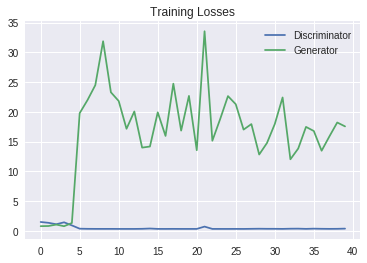

In [29]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.cpu().reshape((28,28)), cmap='Greys_r')

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

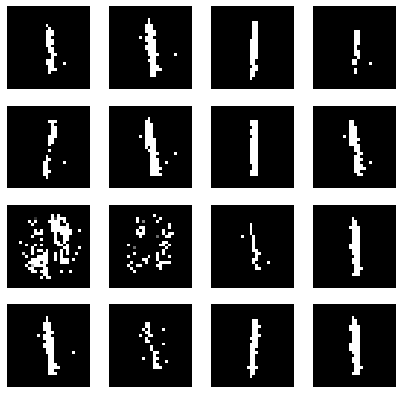

In [38]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

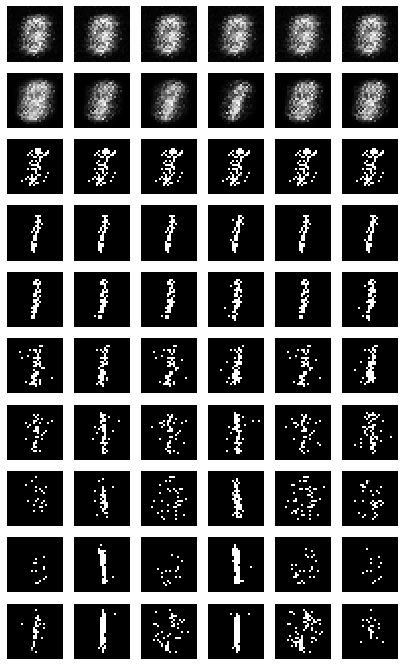

In [40]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.cpu().reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

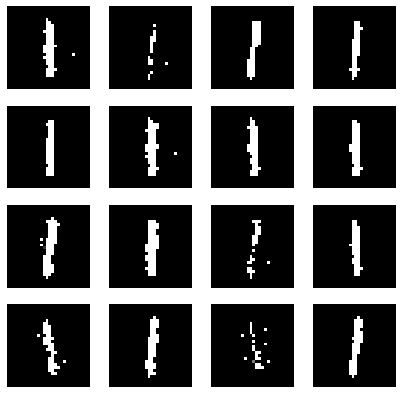

In [42]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()
if train_on_gpu:
    rand_z = rand_z.cuda()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])